In [30]:
%load_ext autoreload
%autoreload 2

In [32]:
import sys
sys.path.append('/Users/gsinyakov/ts_course_summer/')

In [34]:
from load_dataset import Dataset

dataset = Dataset('/Users/gsinyakov/ts_course_summer/data/dataset/')

### В чем заключаются недостатки полносвязных сетей?
* невозможность улавливать временные закономерности в контексте предыдущих точек (архитектурное ограничение)
* фиксированный размер входных данных
* фиксированный размер выходных данных

### Область применимости рекуретных сетей для задачи анализа временных рядов
* большое количество экзогенных признаков, имеющих сложную нелинейную зависимость с целевым рядом
* очень сложная временная структура имеющая наложение разных сезонных и цикличных паттернов
* ряды с часто меняющимся паттерном, или большим количеством аномалий
* когда есть необходимость в нефиксированной длине входных и выходных данных (например многомерные ряды, где для разных компонент хочется предоставить разное количество лагов) 

### Особенности подготовки данных - необходима нормализация данных, иначе сеть будет плохо сходиться и медленно обучаться.

In [39]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

In [12]:
data = np.array(range(0, 100, 10)).reshape(-1, 1)

In [13]:
scaler = MinMaxScaler((0, 1))

In [14]:
scaler.fit(data)

MinMaxScaler()

In [16]:
transformed = scaler.transform(data)

In [17]:
transformed

array([[0.        ],
       [0.11111111],
       [0.22222222],
       [0.33333333],
       [0.44444444],
       [0.55555556],
       [0.66666667],
       [0.77777778],
       [0.88888889],
       [1.        ]])

In [18]:
inverse = scaler.inverse_transform(transformed)

In [19]:
inverse

array([[ 0.],
       [10.],
       [20.],
       [30.],
       [40.],
       [50.],
       [60.],
       [70.],
       [80.],
       [90.]])

### Особенность подготвки данных - обработка последовательностей разной длины.

In [20]:
from keras.preprocessing.sequence import pad_sequences

In [22]:
sequences = [
    [1, 2, 3, 4],
    [3, 4, 5],
    [5, 6],
    [3]
]

In [24]:
pad_sequences(sequences, padding='pre')

array([[1, 2, 3, 4],
       [0, 3, 4, 5],
       [0, 0, 5, 6],
       [0, 0, 0, 3]], dtype=int32)

In [25]:
pad_sequences(sequences, padding='post')

array([[1, 2, 3, 4],
       [3, 4, 5, 0],
       [5, 6, 0, 0],
       [3, 0, 0, 0]], dtype=int32)

In [27]:
pad_sequences(sequences, maxlen=2)

array([[3, 4],
       [4, 5],
       [5, 6],
       [0, 3]], dtype=int32)

In [29]:
pad_sequences(sequences, maxlen=2, truncating='post')

array([[1, 2],
       [3, 4],
       [5, 6],
       [0, 3]], dtype=int32)

### Какие архитектуры lstm нас интересуют в контексте временных рядов?
* one-to-one - предсказание следующей точки по предыдущей - нет
* one-to-many - предсказание следующих N точeк про предыдущей - нет
* many-to-one - one-step-ahead предсказание - в некоторой степени
* many-to-many -  предсказание вектора из следующих m точек по предыдущим n точкам - наибольший интерес

### Простая LSTM сеть

In [51]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

In [37]:
ts = dataset['daily-min-temperatures.csv']

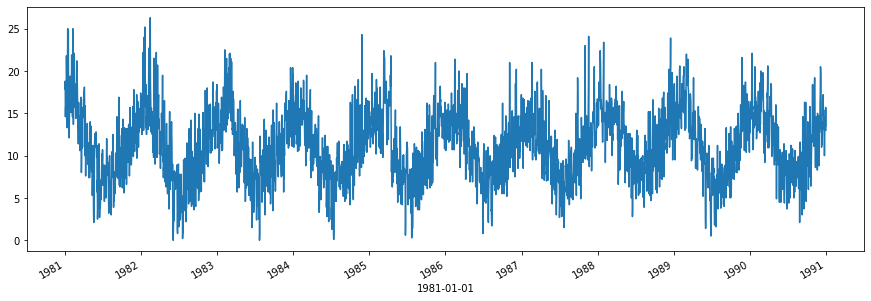

In [43]:
ts.plot(figsize=(15, 5))

In [87]:
def transform_into_matrix(ts: pd.Series, num_lags: int) -> pd.DataFrame:
    """
    Transforms time series into lags matrix to allow
    applying supervised learning algorithms

    Parameters
    ------------
    ts
        Time series to transform
    num_lags
        Number of lags to use

    Returns
    --------
        train, test: np.arrays of shapes (ts-num_lags, num_lags), (num_lags,)
    """

    ts_values = ts.values
    data = {}
    for i in range(num_lags + 1):
        data[f'lag_{num_lags - i}'] = np.roll(ts_values, -i)

    lags_matrix = pd.DataFrame(data)[:-num_lags]
    lags_matrix.index = ts.index[num_lags:]

    return lags_matrix.drop('lag_0', axis=1).values, lags_matrix['lag_0'].values

In [88]:
NUM_LAGS = 14
X, y = transform_into_matrix(ts, NUM_LAGS)

In [89]:
X[0]

array([17.9, 18.8, 14.6, 15.8, 15.8, 15.8, 17.4, 21.8, 20. , 16.2, 13.3,
       16.7, 21.5, 25. ])

In [90]:
X = X.reshape((X.shape[0], X.shape[1], 1))

In [91]:
X[0]

array([[17.9],
       [18.8],
       [14.6],
       [15.8],
       [15.8],
       [15.8],
       [17.4],
       [21.8],
       [20. ],
       [16.2],
       [13.3],
       [16.7],
       [21.5],
       [25. ]])

In [94]:
split_idx = int(len(X)*0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

In [95]:
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(NUM_LAGS, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [96]:
model.fit(X, y, epochs=100)

Epoch 1/100
114/114 [==============================] - 1s 5ms/step - loss: 24.7993
Epoch 2/100
114/114 [==============================] - 1s 5ms/step - loss: 6.2100
Epoch 3/100
114/114 [==============================] - 1s 4ms/step - loss: 5.9427
Epoch 4/100
114/114 [==============================] - 0s 4ms/step - loss: 5.9848
Epoch 5/100
114/114 [==============================] - 1s 5ms/step - loss: 5.9548
Epoch 6/100
114/114 [==============================] - 1s 5ms/step - loss: 5.9400
Epoch 7/100
114/114 [==============================] - 1s 5ms/step - loss: 5.8584
Epoch 8/100
114/114 [==============================] - 1s 5ms/step - loss: 5.8291
Epoch 9/100
114/114 [==============================] - 1s 5ms/step - loss: 5.8180
Epoch 10/100
114/114 [==============================] - 1s 5ms/step - loss: 5.8432
Epoch 11/100
114/114 [==============================] - 1s 5ms/step - loss: 5.7603
Epoch 12/100
114/114 [==============================] - 1s 5ms/step - loss: 5.7874
Epoch 13/100

114/114 [==============================] - 1s 5ms/step - loss: 5.5887
Epoch 100/100
114/114 [==============================] - 1s 5ms/step - loss: 5.5597


In [98]:
y_pred = model.predict(X_test)

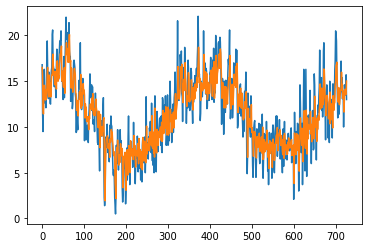

In [104]:
pd.Series(y_test.flatten()).plot()
pd.Series(y_pred.flatten()).plot()

In [105]:
### данный результат на самом деле не сильно лучше наивного предсказания

### Stacked LSTM

#### Добавьте дополнительные скрытые слои в сеть (используйте return_sequences=True) и сравните качество

In [107]:
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(NUM_LAGS, 1)))
# ваш код
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

#### Bidirectional LSTM

#### Сделайте LSTM слой сети Bidirectional при помощи доп слоя Biderectional и сравните качество

In [109]:
from keras.layers import Bidirectional

model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(NUM_LAGS, 1)))
# ваш код
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

### Seq2Seq LSTM - когда нужно сделать предсказание на несколько точек вперед

#### Подготовим данные

In [110]:
from typing import Tuple

def transform_ts_into_matrix(ts: pd.Series, num_lags_in: int, num_lags_out: int) -> Tuple[np.array, np.array]:
    """
    Данная функция должна пройтись скользящим окном по временному ряду и для каждых
    num_lags_in точек в качестве признаков собрать num_lags_out следующих точек в качестве таргета.
    
    Вернуть два np.array массива из X_train и y_train соответственно
    """
    sequence = ts.values
    X, y = list(), list()
    i = 0
    outer_idx = num_lags_out
    while outer_idx < len(sequence):
        inner_idx = i + num_lags_in
        outer_idx = inner_idx + num_lags_out
        X_, y_ = sequence[i:inner_idx], sequence[inner_idx:outer_idx]
        X.append(X_)
        y.append(y_)
        i += 1
    return np.array(X), np.array(y)

In [113]:
# получите X и y при помощи предыдущей функции и разбейте на трейн и тест 
NUM_LAGS_IN = 28
NUM_LAGS_OUT = 7

In [115]:
# объявим енкодер
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(NUM_LAGS_IN, 1)))

In [118]:
# добавим промежуточный слой, преобразующий выход с енкодера для входного слоя в декодер
from keras.layers import RepeatVector
model.add(RepeatVector(NUM_LAGS_OUT))

In [120]:
# обьявим декодер
model.add(LSTM(50, activation='relu', return_sequences=True))

In [122]:
# обьявим выходной слой - размерность на выходе получается при помощи дополнительного слоя TimeDistributed
from keras.layers import TimeDistributed
model.add(TimeDistributed(Dense(1)))

#### Обучите модель и получите предсказание на тесте

In [123]:
# ваш код здесь